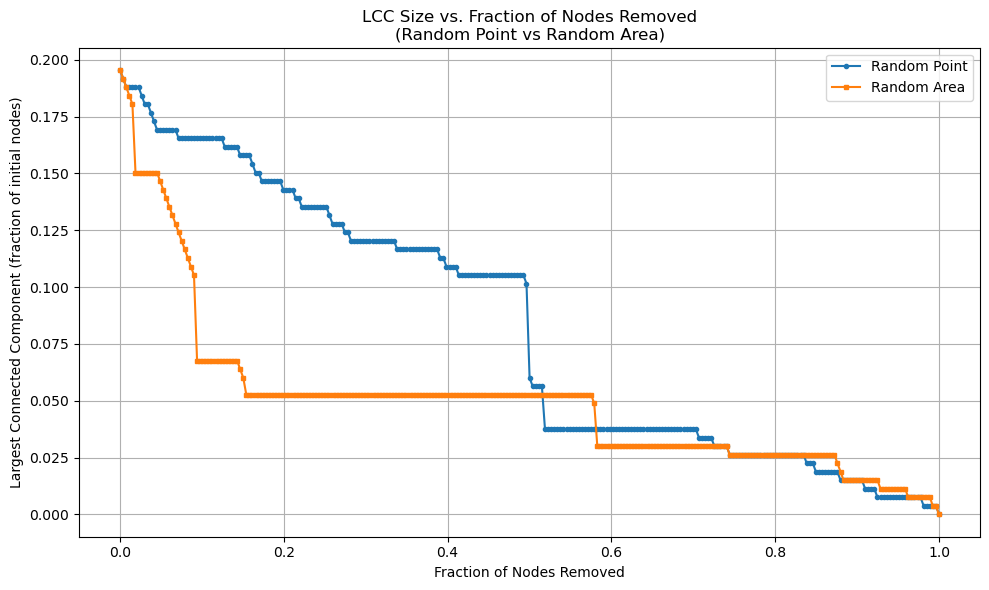

Saved figure: RP_vs_RA.png


In [8]:
import csv
import random
import networkx as nx
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
EDGE_LIST_FILE = 'C:/Users/ak4086/Desktop/H-W Uni/bri_new_wos_coauthorship_edgelist.csv'
FRACTION_REMOVE = 1.0    # e.g., 1.0 = remove all nodes; 0.3 = remove 30% of nodes
SEED = 42                # set None for fully random

# =========================
# Load graph from edge list
# =========================
G = nx.Graph()
with open(EDGE_LIST_FILE, 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    _ = next(reader, None)  # skip header if present
    for row in reader:
        if len(row) >= 2:
            u, v = row[0], row[1]
            G.add_edge(u, v)

# =========================
# Helpers
# =========================
def largest_cc_size(H: nx.Graph) -> int:
    """Size of the largest connected component (0 if empty)."""
    return len(max(nx.connected_components(H), key=len, default=set()))

def target_removals_count(n0: int, fraction_remove) -> int:
    """Convert fraction or absolute count to a valid integer number of removals."""
    if n0 == 0:
        return 0
    if 0 < fraction_remove <= 1:
        return max(1, int(round(n0 * fraction_remove)))
    # treat as absolute count
    return max(0, min(n0, int(fraction_remove)))

# =========================
# Random Point simulation
# =========================
def simulate_random_point(G: nx.Graph, fraction_remove=1.0, seed=None):
    """
    Random Point (RP): each iteration, remove a uniformly random node from all remaining nodes.
    Returns:
        removed_order (list), lcc_sizes (list, includes initial size before any removal)
    """
    rng = random.Random(seed)
    H = G.copy()
    n0 = H.number_of_nodes()
    T = target_removals_count(n0, fraction_remove)
    lcc_sizes = [largest_cc_size(H)]
    removed_order = []

    for _ in range(T):
        if H.number_of_nodes() == 0:
            lcc_sizes.append(0)
            break
        node = rng.choice(tuple(H.nodes()))
        H.remove_node(node)
        removed_order.append(node)
        lcc_sizes.append(largest_cc_size(H))
    return removed_order, lcc_sizes, T

# =========================
# Random Area simulation
# =========================
def simulate_random_area(G: nx.Graph, fraction_remove=1.0, seed=None):
    """
    Random Area (RArea):
      - pick a random seed node and remove it
      - repeatedly remove a random neighbor of the last removed node
      - if no neighbors remain, reseed by picking a new random node
    Returns:
        removed_order (list), lcc_sizes (list, includes initial size before any removal)
    """
    rng = random.Random(seed)
    H = G.copy()
    n0 = H.number_of_nodes()
    T = target_removals_count(n0, fraction_remove)
    lcc_sizes = [largest_cc_size(H)]
    removed_order = []

    if n0 == 0 or T == 0:
        return removed_order, lcc_sizes, T

    # pick initial seed
    current = rng.choice(tuple(H.nodes()))

    while len(removed_order) < T and H.number_of_nodes() > 0:
        # capture neighbors *before* removal
        neighbors_before = list(H.neighbors(current))

        if H.has_node(current):
            H.remove_node(current)
            removed_order.append(current)
            lcc_sizes.append(largest_cc_size(H))

        if len(removed_order) >= T or H.number_of_nodes() == 0:
            break

        # choose next as a random surviving neighbor if possible; otherwise reseed
        neighbors_alive = [n for n in neighbors_before if H.has_node(n)]
        if neighbors_alive:
            current = rng.choice(neighbors_alive)
        else:
            current = rng.choice(tuple(H.nodes()))

    return removed_order, lcc_sizes, T

# =========================
# Run both simulations
# =========================
rp_removed, rp_lcc, rp_T = simulate_random_point(G, FRACTION_REMOVE, SEED)
ra_removed, ra_lcc, ra_T = simulate_random_area(G, FRACTION_REMOVE, SEED)

# =========================
# Prepare x-axis as fraction removed
# (length of lcc arrays is removals + 1, including the initial point)
# =========================
def fractions(len_series, T):
    # indices 0..len_series-1 correspond to 0..#removals; normalize by T (avoid div by 0)
    if T == 0:
        return [0.0] * len_series
    return [i / T for i in range(len_series)]

x_rp = fractions(len(rp_lcc), rp_T)
x_ra = fractions(len(ra_lcc), ra_T)

# Normalize LCC by initial node count for comparability (optional but helpful)
n_initial = G.number_of_nodes()
def normalize(series, n0):
    return [s / n0 if n0 > 0 else 0 for s in series]

rp_lcc_norm = normalize(rp_lcc, n_initial)
ra_lcc_norm = normalize(ra_lcc, n_initial)

# =========================
# Plot both on the same figure
# =========================
plt.figure(figsize=(10, 6))
plt.plot(x_rp, rp_lcc_norm, marker='o', linestyle='-', markersize=3, label='Random Point')
plt.plot(x_ra, ra_lcc_norm, marker='s', linestyle='-', markersize=3, label='Random Area')
plt.title('LCC Size vs. Fraction of Nodes Removed\n(Random Point vs Random Area)')
plt.xlabel('Fraction of Nodes Removed')
plt.ylabel('Largest Connected Component (fraction of initial nodes)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('random_point_vs_area.png', dpi=300)
plt.show()

print("Saved figure: RP_vs_RA.png")